In [1]:
import os
import zipfile

zip_files = [
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip', 
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip', 
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip', 
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip'
]

extract_base_folder = '/kaggle/working/jigsaw-toxic-comment-classification-challenge'

os.makedirs(extract_base_folder, exist_ok=True)

for zip_file in zip_files:
    extract_folder = os.path.join(extract_base_folder, os.path.splitext(os.path.basename(zip_file))[0])
    
    if not os.path.exists(extract_folder):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
        print(f"Extracted {zip_file} to {extract_folder}")
    else:
        print(f"Skipping {zip_file}, {extract_folder} already exists.")

Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/test.csv
Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/test_labels.csv
Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/train.csv


# **Import dependencies**

In [2]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, GRU, Bidirectional, Dense, Dropout,
    SpatialDropout1D, GlobalMaxPooling1D
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings("ignore")

2025-12-02 03:53:03.571204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764647583.785543      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764647583.845478      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
ARTIFACT_DIR = "./artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [4]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [5]:
train_path = "/kaggle/working/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv"
test_path = "/kaggle/working/jigsaw-toxic-comment-classification-challenge/test.csv/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [6]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train_df[label_cols].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [8]:
train_df.shape

(159571, 8)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


- Check for null values

In [10]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# **EDA**

In [11]:
x = train_df.iloc[:, 2:].sum() # Chỉ lấy các cột label
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [12]:
rowsums = train_df.iloc[:, 2:].sum(axis=1) # Lấy các cột label và tính tổng theo từng cột
rowsums

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Length: 159571, dtype: int64

In [13]:
no_label_count = 0

for i, count in rowsums.items():
    if count==0:
        no_label_count += 1
        
print('Tổng số lượng comments: ', len(train_df))
print('Số lượng comment chưa được gán nhãn: ', no_label_count)
print('Số lượng label ', x.sum())

Tổng số lượng comments:  159571
Số lượng comment chưa được gán nhãn:  143346
Số lượng label  35098


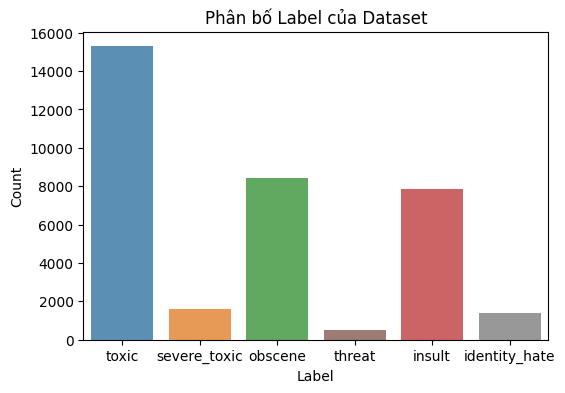

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Phân bố Label của Dataset')
plt.ylabel('Count')
plt.xlabel('Label')

plt.show()

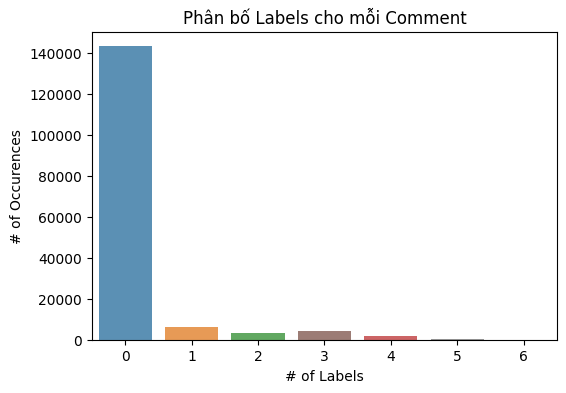

In [15]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Phân bố Labels cho mỗi Comment')
plt.ylabel('# of Occurences')
plt.xlabel('# of Labels')

plt.show()

# **Data Preprocesssing**

In [16]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [17]:
train_df["comment_text"] = train_df["comment_text"].fillna("").apply(clean_text)
test_df["comment_text"]  = test_df["comment_text"].fillna("").apply(clean_text)

# **Split Data**

In [18]:
X = train_df["comment_text"].values
y = train_df[label_cols].values.astype("float32")

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
    stratify=(y.sum(axis=1) > 0)
)

In [20]:
print("Train size:", len(X_train))
print("Val size  :", len(X_val))

Train size: 143613
Val size  : 15958


# **Label weights and Metrics**

In [21]:
pos_freq = y_train.mean(axis=0)
print("Positive frequency per label:")
for name, freq in zip(label_cols, pos_freq):
    print(f"{name}: {freq:.5f}")

Positive frequency per label:
toxic: 0.09588
severe_toxic: 0.01011
obscene: 0.05308
threat: 0.00304
insult: 0.04943
identity_hate: 0.00886


In [22]:
label_weights = 1.0 / (pos_freq + 1e-6)
label_weights = label_weights / label_weights.max()

print("\nLabel weights (normalized):")
for name, w in zip(label_cols, label_weights):
    print(f"{name}: {w:.3f}")


Label weights (normalized):
toxic: 0.032
severe_toxic: 0.300
obscene: 0.057
threat: 1.000
insult: 0.061
identity_hate: 0.343


In [23]:
label_weights_tf = tf.constant(label_weights, dtype=tf.float32)

I0000 00:00:1764647607.363959      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [24]:
# Weighted BCE for multi-label (Keras)

def weighted_bce_multi(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(bce * label_weights_tf)

# **Bidirectional GRU Model**

In [25]:
MAX_NUM_WORDS = 100_000
MAX_LEN = 220

## **Tokenizer và Sequences**

In [26]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(test_df["comment_text"].values)

X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_seq   = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test_seq  = pad_sequences(X_test_seq, maxlen=MAX_LEN)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

print("Vocab size:", len(word_index))
print("Using num_words:", num_words)

Vocab size: 196963
Using num_words: 100000


## **Load fastText vectors**

In [27]:
FASTTEXT_PATH = "/kaggle/input/fast-text-word-embeddings/wiki-news-300d-1M.vec"

EMBEDDING_DIM = 300
embeddings_index = {}

embedding_matrix = np.random.normal(0, 0.01, (num_words, EMBEDDING_DIM)).astype("float32")

bad_lines = 0
found = 0

with open(FASTTEXT_PATH, "r", encoding="utf-8", newline="\n", errors="ignore") as f:
    # Đọc thử dòng đầu xem có phải header "num_words dim" không
    header = f.readline().rstrip().split(" ")
    if len(header) != 2 or not header[0].isdigit():
        # Không phải header chuẩn → quay lại đầu file, xử lý tất cả như data
        f.seek(0)

    for line in f:
        values = line.rstrip().split(" ")
        # cần ít nhất 1 từ + 300 số
        if len(values) < EMBEDDING_DIM + 1:
            bad_lines += 1
            continue

        word = values[0]
        vector_str = values[1:]

        try:
            coefs = np.asarray(vector_str, dtype="float32")
        except ValueError:
            # Dòng này có kí tự binary / không convert được → bỏ
            bad_lines += 1
            continue

        # Chỉ set embedding nếu từ nằm trong vocab tokenizer
        idx = word_index.get(word)
        if idx is not None and idx < num_words:
            embedding_matrix[idx] = coefs
            found += 1

print("FastText loading done.")
print("  Found vectors for", found, "words in vocab.")
print("  Skipped bad / short lines:", bad_lines)
print("Embedding matrix shape:", embedding_matrix.shape)

FastText loading done.
  Found vectors for 0 words in vocab.
  Skipped bad / short lines: 2721933
Embedding matrix shape: (100000, 300)


## **Build Model**

In [28]:
def build_bigru_fasttext_model():
    model = Sequential()
    model.add(
        Embedding(
            input_dim=num_words,
            output_dim=EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_LEN,
            trainable=False  
        )
    )
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(len(label_cols), activation="sigmoid"))

    model.compile(
        loss=weighted_bce_multi,  # uses label_weights_tf
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=["accuracy"]
    )
    return model

In [29]:
bigru_model = build_bigru_fasttext_model()
bigru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    30,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,000,000 (114.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 30,000,000 (114.44 MB)

In [30]:
EPOCHS = 6
BATCH_SIZE = 256

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=1, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True, verbose=1
    )
]

history_bigru = bigru_model.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/6


I0000 00:00:1764647645.810094     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


561/561 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.5601 - loss: 0.0383 - val_accuracy: 0.9939 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 2/6
561/561 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.9353 - loss: 0.0142 - val_accuracy: 0.9939 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 3/6
561/561 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.9927 - loss: 0.0104 - val_accuracy: 0.9939 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 4/6
561/561 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.9940 - loss: 0.0096 - val_accuracy: 0.9939 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 5/6
561/561 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.9940 - loss: 0.0090 - val_accuracy: 0.9939 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 6/6
561/561 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.9941 - loss: 0.0085 - val_accuracy: 0.9939 - val_loss: 0.0077 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 6.


## **Validation metrics and Submission**

In [31]:
y_val_pred_proba = bigru_model.predict(X_val_seq, batch_size=256, verbose=1)
y_val_pred = (y_val_pred_proba > 0.5).astype("int32")

print(classification_report(y_val, y_val_pred, target_names=label_cols, digits=4))
print("Micro F1:", f1_score(y_val, y_val_pred, average="micro"))
print("Macro F1:", f1_score(y_val, y_val_pred, average="macro"))

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
               precision    recall  f1-score   support

        toxic     0.9030    0.4761    0.6234      1525
 severe_toxic     0.4464    0.1748    0.2513       143
      obscene     0.8264    0.6283    0.7139       826
       threat     0.0000    0.0000    0.0000        42
       insult     0.7495    0.5077    0.6054       778
identity_hate     0.0000    0.0000    0.0000       132

    micro avg     0.8263    0.4832    0.6098      3446
    macro avg     0.4876    0.2978    0.3657      3446
 weighted avg     0.7854    0.4832    0.5941      3446
  samples avg     0.0407    0.0383    0.0376      3446

Micro F1: 0.6097784288591833
Macro F1: 0.3656594189744447


In [32]:
test_pred_proba_bigru = bigru_model.predict(X_test_seq, batch_size=256, verbose=1)

submission_bigru = pd.DataFrame(test_pred_proba_bigru, columns=label_cols)
submission_bigru.insert(0, "id", test_df["id"].values)
submission_bigru.to_csv("submission_bigru_fasttext.csv", index=False)

599/599 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step


## **Save model và Artifacts**

In [33]:
# Save BiGRU model 
bigru_model_path = os.path.join(ARTIFACT_DIR, "bigru_fasttext.h5")
bigru_model.save(bigru_model_path)
print("Saved BiGRU model to:", bigru_model_path)

# Save BiGRU tokenizer 
tokenizer_path = os.path.join(ARTIFACT_DIR, "tokenizer_bigru.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)
print("Saved BiGRU tokenizer to:", tokenizer_path)

Saved BiGRU model to: ./artifacts/bigru_fasttext.h5
Saved BiGRU tokenizer to: ./artifacts/tokenizer_bigru.pkl


# **RoBERTa (HuggingFace)**

In [34]:
%pip install -q "transformers==4.46.0" "protobuf==3.20.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.4 MB/s eta 0:00:00
Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 76.0 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 83.6 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompa

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
MODEL_NAME = "roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN_ROBERTA = 220

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## **Dataset and Dataloader**

In [37]:
class JigsawDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=220):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
        }
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

In [38]:
BATCH_SIZE_ROBERTA = 16

train_dataset_roberta = JigsawDataset(
    X_train, y_train, tokenizer=tokenizer_roberta, max_len=MAX_LEN_ROBERTA
)
val_dataset_roberta = JigsawDataset(
    X_val, y_val, tokenizer=tokenizer_roberta, max_len=MAX_LEN_ROBERTA
)

train_loader = DataLoader(train_dataset_roberta, batch_size=BATCH_SIZE_ROBERTA, shuffle=True)
val_loader   = DataLoader(val_dataset_roberta, batch_size=BATCH_SIZE_ROBERTA, shuffle=False)

## **Model và Losses**

In [39]:
model_roberta = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
)
model_roberta.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [40]:
pos_freq_t = torch.tensor(pos_freq, dtype=torch.float, device=device)
label_weights_t = 1.0 / (pos_freq_t + 1e-6)
label_weights_t = label_weights_t / label_weights_t.max()

criterion = torch.nn.BCEWithLogitsLoss(pos_weight=label_weights_t)

EPOCHS_ROBERTA = 3
LR = 2e-5
optimizer = torch.optim.AdamW(model_roberta.parameters(), lr=LR)

num_training_steps = EPOCHS_ROBERTA * len(train_loader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

## **Training**

In [41]:
def train_one_epoch(model, data_loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(data_loader, desc="Train", leave=False)

    for step, batch in enumerate(progress_bar, start=1):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        avg_loss = total_loss / step

        progress_bar.set_postfix(loss=f"{avg_loss:.4f}")

    return total_loss / len(data_loader)



def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(data_loader, desc="Val", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    preds_bin = (all_preds > 0.5).astype("int32")

    micro_f1 = f1_score(all_labels, preds_bin, average="micro")
    macro_f1 = f1_score(all_labels, preds_bin, average="macro")

    return total_loss / len(data_loader), micro_f1, macro_f1

In [42]:
ROBERTA_SAVE_DIR = os.path.join(ARTIFACT_DIR, "roberta_multi")
os.makedirs(ROBERTA_SAVE_DIR, exist_ok=True)

ROBERTA_STATE_PATH = os.path.join(ARTIFACT_DIR, "best_roberta_multi_state_dict.pth")

In [43]:
best_macro_f1 = 0.0

for epoch in range(1, EPOCHS_ROBERTA + 1):
    print(f"\nEpoch {epoch}/{EPOCHS_ROBERTA}")

    train_loss = train_one_epoch(model_roberta, train_loader, optimizer, scheduler, criterion, device)
    val_loss, micro_f1, macro_f1 = eval_model(model_roberta, val_loader, criterion, device)

    print(f"  Train loss: {train_loss:.4f}")
    print(f"  Val loss  : {val_loss:.4f}")
    print(f"  Micro F1  : {micro_f1:.4f}")
    print(f"  Macro F1  : {macro_f1:.4f}")

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1

        # 1) Save full HF model + tokenizer
        model_roberta.save_pretrained(ROBERTA_SAVE_DIR)
        tokenizer_roberta.save_pretrained(ROBERTA_SAVE_DIR)

        # 2) also save state_dict backup
        torch.save(model_roberta.state_dict(), ROBERTA_STATE_PATH)

        print(f"  --> New best model saved (macro F1 = {macro_f1:.4f})")
        print(f"      HF folder : {ROBERTA_SAVE_DIR}")
        print(f"      state_dict: {ROBERTA_STATE_PATH}")


Epoch 1/3


Train:   0%|          | 0/8976 [00:00<?, ?it/s]

Val:   0%|          | 0/998 [00:00<?, ?it/s]

  Train loss: 0.0281
  Val loss  : 0.0092
  Micro F1  : 0.4654
  Macro F1  : 0.3590
  --> New best model saved (macro F1 = 0.3590)
      HF folder : ./artifacts/roberta_multi
      state_dict: ./artifacts/best_roberta_multi_state_dict.pth

Epoch 2/3


Train:   0%|          | 0/8976 [00:00<?, ?it/s]

Val:   0%|          | 0/998 [00:00<?, ?it/s]

  Train loss: 0.0084
  Val loss  : 0.0089
  Micro F1  : 0.5656
  Macro F1  : 0.4494
  --> New best model saved (macro F1 = 0.4494)
      HF folder : ./artifacts/roberta_multi
      state_dict: ./artifacts/best_roberta_multi_state_dict.pth

Epoch 3/3


Train:   0%|          | 0/8976 [00:00<?, ?it/s]

Val:   0%|          | 0/998 [00:00<?, ?it/s]

  Train loss: 0.0069
  Val loss  : 0.0088
  Micro F1  : 0.5808
  Macro F1  : 0.5036
  --> New best model saved (macro F1 = 0.5036)
      HF folder : ./artifacts/roberta_multi
      state_dict: ./artifacts/best_roberta_multi_state_dict.pth


## **Test and submit**

In [44]:
# Load best weights
best_model = AutoModelForSequenceClassification.from_pretrained(
    ROBERTA_SAVE_DIR,
    local_files_only=True
)
best_model.to(device)
best_model.eval()
best_tokenizer = AutoTokenizer.from_pretrained(ROBERTA_SAVE_DIR, local_files_only=True)

In [ ]:
test_dataset_roberta = JigsawDataset(
    test_df["comment_text"].values,
    labels=None,
    tokenizer=best_tokenizer,     # use best_tokenizer
    max_len=MAX_LEN_ROBERTA
)
test_loader_roberta = DataLoader(test_dataset_roberta, batch_size=BATCH_SIZE_ROBERTA, shuffle=False)

all_test_preds = []
with torch.no_grad():
    for batch in test_loader_roberta:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        all_test_preds.append(probs)

test_pred_proba_roberta = np.vstack(all_test_preds)

In [ ]:
submission_roberta = pd.DataFrame(test_pred_proba_roberta, columns=label_cols)
submission_roberta.insert(0, "id", test_df["id"].values)
submission_roberta.to_csv("submission_roberta.csv", index=False)